In [1]:
from PIL import Image, ImageDraw
import numpy as np
import matplotlib.pyplot as plt
import math
from heapq import heappop, heappush
import queue

class Map:

    def __init__(self):
        '''
        Default constructor
        '''

        self._width = 0
        self._height = 0
        self._cells = []
    

    def read_from_string(self, cell_str, width, height):
        '''
        Converting a string (with '#' representing obstacles and '.' representing free cells) to a grid
        '''
        self._width = width
        self._height = height
        self._cells = [[0 for _ in range(width)] for _ in range(height)]
        cell_lines = cell_str.split("\n")
        i = 0
        j = 0
        for l in cell_lines:
            if len(l) != 0:
                j = 0
                for c in l:
                    if c == '.':
                        self._cells[i][j] = 0
                    elif c == '#':
                        self._cells[i][j] = 1
                    else:
                        continue
                    j += 1
                if j != width:
                    raise Exception("Size Error. Map width = ", j, ", but must be", width )
                
                i += 1

        if i != height:
            raise Exception("Size Error. Map height = ", i, ", but must be", height )
    
     
    def set_grid_cells(self, width, height, grid_cells):
        '''
        Initialization of map by list of cells.
        '''
        self._width = width
        self._height = height
        self._cells = grid_cells


    def in_bounds(self, i, j):
        '''
        Check if the cell is on a grid.
        '''
        return (0 <= j < self._width) and (0 <= i < self._height)
    

    def traversable(self, i, j):
        '''
        Check if the cell is not an obstacle.
        '''
        return not self._cells[i][j]
    
    def get_neighbors(self, i, j):
        '''
        Get a list of neighbouring cells as (i,j) tuples.
        It's assumed that grid is 8-connected but cutting corners is prohibited
        '''
        neighbors = []
        delta = [[0, 1], [1, 0], [0, -1], [-1, 0]]
        for d in delta:
            if self.in_bounds(i + d[0], j + d[1]) and self.traversable(i + d[0], j + d[1]):
                neighbors.append((i + d[0], j + d[1]))
                
        delta = [[1, 1], [1, -1], [-1, 1], [-1, -1]]
        for d in delta:
            if self.in_bounds(i + d[0], j + d[1]) and self.traversable(i + d[0], j + d[1]) and \
            (self.traversable(i + d[0], j) or self.traversable(i, j + d[1])):
                neighbors.append((i + d[0], j + d[1]))

        return neighbors

    def get_size(self):
        return (self._height, self._width)

In [2]:
def compute_cost(i1, j1, i2, j2):
    '''
    Computes cost of a move between the adjacent cells
    '''
    if abs(i1 - i2) + abs(j1 - j2) == 1: #cardinal move
        return 1
    elif abs(i1 - i2) + abs(j1 - j2) == 2: #diagonal move
        return math.sqrt(2)
    else:
        raise Exception('Trying to compute the cost of a non-supported move! ONLY cardinal and diagonal moves are supported.')

In [3]:
class Node:
    '''
    Node class represents a search node

    - i, j: coordinates of corresponding grid element
    - g: g-value of the node
    - h: h-value of the node
    - F: f-value of the node
    - parent: pointer to the parent-node 

    You might want to add other fields/methods for Node
    '''

    def __init__(self, i, j, g = 0, h = 0, F = None, parent = None, k = 0):
        self.i = i
        self.j = j
        self.g = g
        self.h = h
        if F is None:
            self.F = self.g + h
        else:
            self.F = F        
        self.parent = parent

    
    def __eq__(self, other):
        return (self.i == other.i) and (self.j == other.j)
    
    def __lt__(self, other):
        return self.F < other.F or ((self.F == other.F) and (self.h < other.h))

In [4]:
class Open:
    
    def __init__(self):
        self.elements = {}
        self.heap = []
    
    def __iter__(self):
        return iter(self.elements)
    
    def __len__(self):
        return len(self.elements)

    def isEmpty(self):
        if len(self.elements) != 0:
            return False
        
        return True

    def AddNode(self, node : Node, *args):
        if (node.i, node.j) not in self.elements or self.elements[(node.i, node.j)].g > node.g:
            self.elements.update({(node.i, node.j) : node})
            heappush(self.heap, node)
            
        return

    def GetBestNode(self, CLOSED, *args):
        best = heappop(self.heap)
        while CLOSED.WasExpanded(best):
            best = heappop(self.heap)
        del self.elements[(best.i, best.j)]
        return best

In [5]:
class Closed:
    
    def __init__(self):
        self.elements = {}


    def __iter__(self):
        return iter(self.elements)
    

    def __len__(self):
        return len(self.elements)


    def AddNode(self, item : Node):
        self.elements.update({(item.i, item.j) : item})


    def WasExpanded(self, item : Node):
        return (item.i, item.j) in self.elements

In [6]:
def diagonal_distance(i1, j1, i2, j2):
    return abs(abs(int(i1) - int(i2)) - abs(int(j1) - int(j2))) + \
            math.sqrt(2) * min(abs(int(i1) - int(i2)), abs(int(j1) - int(j2)))

In [7]:
def astar(grid_map, start_i, start_j, goal_i, goal_j, heuristic_func):

    OPEN = Open()
    CLOSED = Closed()
    
    start_node = Node(start_i, start_j, 0, heuristic_func(start_i, start_j, goal_i, goal_j))
    goal_node = Node(goal_i, goal_j, 0, 0)
    OPEN.AddNode(start_node)
    
    while not OPEN.isEmpty():
        next_node = OPEN.GetBestNode(CLOSED)
        CLOSED.AddNode(next_node)
    
        if next_node == goal_node:
            return (True, next_node, CLOSED.elements.values(), OPEN.elements.values())
            
        
        for nbr_node in grid_map.get_neighbors(next_node.i, next_node.j):
            if not CLOSED.WasExpanded(Node(i=nbr_node[0], j=nbr_node[1])):
                OPEN.AddNode( Node(i=nbr_node[0], 
                                   j=nbr_node[1], 
                                   g=next_node.g + compute_cost(next_node.i, next_node.j, nbr_node[0], nbr_node[1]), 
                                   h=heuristic_func(nbr_node[0], nbr_node[1], goal_i, goal_j),
                                   parent=next_node) )
                

    return False, None, CLOSED, OPEN

In [8]:
def make_path(goal):
    '''
    Creates a path by tracing parent pointers from the goal node to the start node
    It also returns path's length.
    '''

    length = goal.g
    current = goal
    path = []
    while current.parent:
        path.append(current)
        current = current.parent
    path.append(current)
    return path[::-1], length

In [9]:
def read_map_from_movingai_file(path):
    
    mapFile = open(path)
    count = 0
    
    mapFile.readline()
    a = mapFile.readline().split(' ')
    height = int(a[1])
    a = mapFile.readline().split(' ')
    width = int(a[1])
    mapFile.readline()
    cells = [[0 for _ in range(width)] for _ in range(height)]
    i = 0
    j = 0

    for l in mapFile:
        j = 0
        for c in l:
            if c == '.' or c == 'G':
                cells[i][j] = 0
            elif c == '@' or c == 'O' or c == 'T':
                cells[i][j] = 1
            else:
                continue
            
            j += 1
            
        if j != width:
            raise Exception("Size Error. Map width = ", j, ", but must be", width, "(map line: ", i, ")")
                
        i += 1
        if(i == height):
            break  

    return (width, height, cells)

In [10]:
def read_tasks_from_movingai_file(path):

    tasksFile = open(path)
    tasks = []
    
    tasksFile.readline()
    for _ in range(200):
        line = tasksFile.readline().split('\t')
        mapFile = line[1]
        jStart = int(line[4])
        iStart = int(line[5])
        jGoal = int(line[6])
        iGoal = int(line[7])
        length = float(line[8])
        
        tasks.append((iStart, jStart, iGoal, jGoal, length))
    
    return tasks 

In [11]:
def Draw(gridMap : Map, start : Node = None, goal : Node = None, path : list = None, nodesExpanded = None, nodesOpened = None):
    '''
    Auxiliary function that visualizes the enviromnet, the path and OPEN and CLOSED.
    '''
    k = 5
    hIm = gridMap._height * k
    wIm = gridMap._width * k
    im = Image.new('RGB', (wIm, hIm), color = 'white')
    draw = ImageDraw.Draw(im)
    for i in range(gridMap._height):
        for j in range(gridMap._width):
            if(gridMap._cells[i][j] == 1):
                draw.rectangle((j * k, i * k, (j + 1) * k - 1, (i + 1) * k - 1), fill=( 70, 80, 80 ))

    if nodesOpened is not None:
        for node in nodesOpened:
            draw.rectangle((node.j * k, node.i * k, (node.j + 1) * k - 1, (node.i + 1) * k - 1), fill=(213, 219, 219), width=0)

    if nodesExpanded is not None:
        for node in nodesExpanded:
            draw.rectangle((node.j * k, node.i * k, (node.j + 1) * k - 1, (node.i + 1) * k - 1), fill=( 131, 145, 146 ), width=0)

    if path is not None:
        for step in path:
            if (step is not None):
                if (gridMap.traversable(step.i, step.j)):
                    draw.rectangle((step.j * k, step.i * k, (step.j + 1) * k - 1, (step.i + 1) * k - 1), fill=(52, 152, 219), width=0)
                else:
                    draw.rectangle((step.j * k, step.i * k, (step.j + 1) * k - 1, (step.i + 1) * k - 1), fill=(230, 126, 34), width=0)

    if (start is not None) and (gridMap.traversable(start.i, start.j)):
        draw.rectangle((start.j * k, start.i * k, (start.j + 1) * k - 1, (start.i + 1) * k - 1), fill=(40, 180, 99), width=0)
    
    if (goal is not None) and (gridMap.traversable(goal.i, goal.j)):
        draw.rectangle((goal.j * k, goal.i * k, (goal.j + 1) * k - 1, (goal.i + 1) * k - 1), fill=(231, 76, 60), width=0)


    fig, ax = plt.subplots(dpi=150)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(np.asarray(im))

In [12]:
def massive_test(search_function, *args):
    all_tasks_results = dict()
    count = 0
    averageNodes = 0
    averageSteps = 0
    
    all_tasks_results["corr"] = []
    all_tasks_results["len"] = []
    all_tasks_results["nc"] = []
    all_tasks_results["st"] = []
    taskNum = 1
    taskMap = Map()
    for taskCount in range(1, taskNum + 1):
        count = 0
        averageNodes = 0
        averageSteps = 0
        print('')
        print('!!!!!!!!!!!!!!!!!!!!!!!!!!!! Карта ' + str(taskCount) + ' !!!!!!!!!!!!!!!!!!!!!!!!!!!!')
        mapFileName = "./maps/" + "den011d" + ".map"
        taskFileName = "./maps/" + "den011d" + ".map.scen"
        width, height, cells = read_map_from_movingai_file(mapFileName)
        tasks = read_tasks_from_movingai_file(taskFileName)
        
        i = 0
        taskMap.set_grid_cells(width,height,cells)
        for task in tasks:
            i += 1
            iStart, jStart, iGoal, jGoal, length = task
            try:
                result = search_function(taskMap, iStart, jStart, iGoal, jGoal, *args)
                nodesExpanded = result[2]
                nodesOpened = result[3]
                if result[0]:
                    path = make_path(result[1]) 
                    all_tasks_results["len"].append(path[1])
                    correct = int(path[1])  == int(length)
                    if correct:
                        count += 1
                    all_tasks_results["corr"].append(correct)
                    averageNodes += len(nodesOpened)
                    averageNodes += len(nodesExpanded)
                    averageSteps += len(nodesExpanded)
                    if (i == 164):
                        Draw(taskMap, Node(iStart, jStart), Node(iGoal, jGoal))
                    print("Path found! Length: " + str(path[1]) + ". Visited: " + str(len(nodesOpened) + len(nodesExpanded)) + ". Expanded: " + str(len(nodesExpanded)) + ". Correct: " + str(correct))
                else:
                    #print("Path not found! " + str(iStart) + ", " + str(jStart) + "; " + str(iGoal) + ", " + str(jGoal))
                    all_tasks_results["corr"].append(False)
                    all_tasks_results["len"].append(0.0)

                all_tasks_results["nc"].append(len(nodesOpened) + len(nodesExpanded))
                all_tasks_results["st"].append(len(nodesExpanded))

            except Exception as e:
                print("Execution error")
                print(e)
                
        print("Success rate: " + str(count / 200 * 100) + "%; average nodes: " +\
                str(averageNodes / 800) + "; average steps: " + str(averageSteps / 800))

    return all_tasks_results


!!!!!!!!!!!!!!!!!!!!!!!!!!!! Карта 1 !!!!!!!!!!!!!!!!!!!!!!!!!!!!
Path found! Length: 3.414213562373095. Visited/OPEN + CLOSED: 17. Expanded: 4. Correct: True
Path found! Length: 2.414213562373095. Visited/OPEN + CLOSED: 14. Expanded: 3. Correct: True
Path found! Length: 2.8284271247461903. Visited/OPEN + CLOSED: 14. Expanded: 3. Correct: True
Path found! Length: 2.414213562373095. Visited/OPEN + CLOSED: 14. Expanded: 3. Correct: True
Path found! Length: 2.414213562373095. Visited/OPEN + CLOSED: 14. Expanded: 3. Correct: True
Path found! Length: 3.82842712474619. Visited/OPEN + CLOSED: 17. Expanded: 4. Correct: True
Path found! Length: 2. Visited/OPEN + CLOSED: 12. Expanded: 3. Correct: True
Path found! Length: 2.414213562373095. Visited/OPEN + CLOSED: 14. Expanded: 3. Correct: True
Path found! Length: 2.414213562373095. Visited/OPEN + CLOSED: 13. Expanded: 3. Correct: True
Path found! Length: 3.82842712474619. Visited/OPEN + CLOSED: 17. Expanded: 4. Correct: True
Path found! Length: 

Path found! Length: 45. Visited/OPEN + CLOSED: 141. Expanded: 46. Correct: True
Path found! Length: 44.65685424949237. Visited/OPEN + CLOSED: 210. Expanded: 115. Correct: True
Path found! Length: 46.0416305603426. Visited/OPEN + CLOSED: 221. Expanded: 119. Correct: True
Path found! Length: 47.656854249492376. Visited/OPEN + CLOSED: 165. Expanded: 75. Correct: True
Path found! Length: 44.11269837220807. Visited/OPEN + CLOSED: 198. Expanded: 95. Correct: True
Path found! Length: 44.76955262170046. Visited/OPEN + CLOSED: 246. Expanded: 135. Correct: False
Path found! Length: 44.11269837220808. Visited/OPEN + CLOSED: 496. Expanded: 391. Correct: True
Path found! Length: 50.698484809835. Visited/OPEN + CLOSED: 225. Expanded: 125. Correct: False
Path found! Length: 49.142135623730944. Visited/OPEN + CLOSED: 386. Expanded: 306. Correct: True
Path found! Length: 47.59797974644665. Visited/OPEN + CLOSED: 395. Expanded: 310. Correct: False
Path found! Length: 49.79898987322333. Visited/OPEN + CL

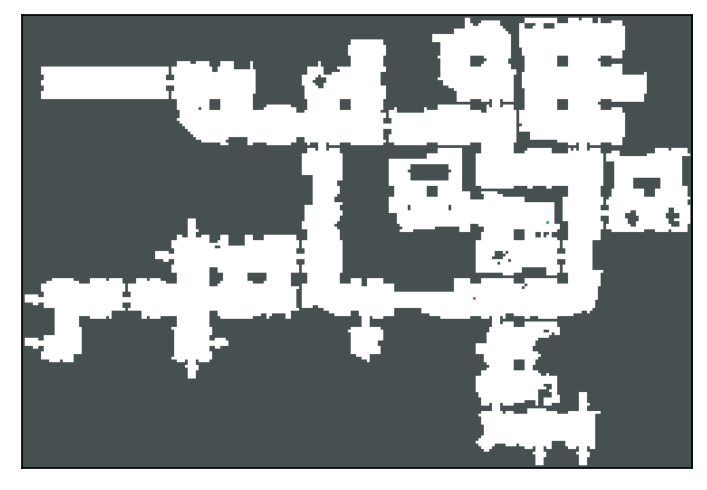

In [13]:
%time astar_corner = massive_test(astar, diagonal_distance)

In [14]:
from __future__ import print_function

import itertools, heapq

# Define some constants representing the things that can be in a field.
OBSTACLE = -10
DESTINATION = -2
UNINITIALIZED = -1

DEBUG = False  
VISUAL = True
expanded = [[False for j in range(150)] for i in range(200)]  
visited = [[False for j in range(150)] for i in range(200)]


class FastPriorityQueue():

    def __init__(self):
        self.pq = []                         # list of entries arranged in a heap
        self.counter = itertools.count()     # unique sequence count

    def add_task(self, task, priority=0, h=0):
        'Add a new task'
        count = next(self.counter)
        entry = [priority, h, count, task]
        heapq.heappush(self.pq, entry)

    def pop_task(self):
        'Remove and return the lowest priority task. Raise KeyError if empty.'
        while self.pq:
            priority, h, count, task = heapq.heappop(self.pq)
            return task
        raise KeyError('pop from an empty priority queue')

    def empty(self):
        return len(self.pq) == 0

# def generate_field(terrain, walkable_fcn, pad=False):
#     """
#     Generate a field from any format as long as a function is provided to determine whether a cell is walkable. 

#     Parameters
#     terrain - a 2d rectangular iterable somehow representing the terrain.
#     walkable_fcn - a function that takes a a cell from terrain as an argument and returns whether that cell can be walked on.
#     pad - if true, this function sets the outermost layer of the map to obstacles. if not, the function does nothing.

#     Returns:
#     the field
#     """
#     field = [[UNINITIALIZED if walkable_fcn(j) else OBSTACLE for j in i] for i in terrain]
#     if pad:
#         pad_field(field)
#     return field 
        
# def pad_field(field):
#     """
#     Fill the outer border of a field with obstacles

#     Parameters
#     field - a 2d rectangular array with obstacles.

#     Returns:
#     None
#     """
#     for i in range(len(field)):
#         field[i][0] = OBSTACLE
#         field[i][-1] = OBSTACLE
#     for j in range(len(field[0])):
#         field[0][j] = OBSTACLE
#         field[-1][j] = OBSTACLE

# def load_obstacle_image(img_name, obstacle_colour=0xFFFFFF):
#     """
#     Loads a field from an image, where the obstacles are marked. PNG or BMP are the best because they're lossless
#     Requires pygame.

#     Returns a field that can be used in jps. 
    
#     img_name - a filename for a .png or .bmp file. 
#     obstacle_colour - the colour that represents obstacles in form 0xABCDEF
#     """
#     import pygame
#     image = pygame.surfarray.array3d(pygame.image.load(img_name))
#     obstacle_colour = (obstacle_colour // 0x10000, obstacle_colour // 0x100 % 0x100, obstacle_colour % 0x100)

#     return generate_field(image, lambda x:(x!=obstacle_colour).any(), pad=True) 

# def load_path_image(img_name, path_colour=0x000000):
#     """
#     Loads a field from an image where the paths are marked. PNG or BMP are the best.
#     This is pretty much the oopposite of load_obstacle_image. 
#     Requires pygame.

#     Returns a field that can be used in jps.

#     img_name - a filename for a .png or .bmp file. 
#     obstacle_colour - the colour that represents obstacles as an int
#     """
    
#     import pygame
#     image = pygame.surfarray.array3d(pygame.image.load(img_name))
#     path_colour = (path_colour // 0x10000, path_colour // 0x100 % 0x100, path_colour % 0x100)

#     return generate_field(image, lambda x:(x==path_colour).all(), pad=True)


def sign(curr, ances):
    if curr - ances > 0:
        return 1
    if curr - ances == 0:
        return 0
    if curr - ances < 0:
        return -1

def jps(field, start_x, start_y, end_x, end_y):
    """
    Run a jump point search on a field with obstacles.
    
    Parameters
    field            - 2d array representing the cost to get to that node.
    start_x, start_y - the x, y coordinates of the starting position (must be ints)
    end_x, end_y     - the x, y coordinates of the destination (must be ints)

    Return:
    a list of tuples corresponding to the jump points. drawing straight lines betwen them gives the path.
    OR
    [] if no path is found. 
    """
    global expanded, visited
    if VISUAL:
        expanded = [[False for j in range(len(field[0]))] for i in range(len(field))]  
        visited = [[False for j in range(len(field[0]))] for i in range(len(field))]  
        
    
    # handle obvious exception cases: either start or end is unreachable
    if field[start_x][start_y] == OBSTACLE:
        raise ValueError("No path exists: the start node is not walkable")
    if field[end_x][end_y] == OBSTACLE:
        raise ValueError("No path exists: the end node is not walkable")

    
    import queue 

    class FoundPath(Exception):
        """ Raise this when you found a path. it's not really an error,
        but I need to stop the program and pass it up to the real function"""
        pass

    def queue_jumppoint(node):
        """
        Add a jump point to the priority queue to be searched later. The priority is the minimum possible number of steps to the destination. 
        Also check whether the search is finished.

        Parameters
        pq - a priority queue for the jump point search
        node - 2-tuple with the coordinates of a point to add.

        Return
        None
        """
        if node is not None:
            pq.add_task (node, field [node[0]] [node[1]] + 2**(0.5)*min(abs(node[0] - end_x), abs(node[1] - end_y)) +\
                         max(abs(node[0] - end_x), abs(node[1] - end_y)) - min(abs(node[0] - end_x), abs(node[1] - end_y)),
                         2**(0.5) * min(abs(node[0] - end_x), abs(node[1] - end_y)) +\
                         max(abs(node[0] - end_x), abs(node[1] - end_y)) - min(abs(node[0] - end_x), abs(node[1] - end_y)))

            
    def _jps_explore_diagonal (startX, startY, directionX, directionY):
        """
        Explores field along the diagonal direction for JPS, starting at point (startX, startY)

        Parameters
        startX, startY - the coordinates to start exploring from. 
        directionX, directionY - an element from: {(1, 1), (-1, 1), (-1, -1), (1, -1)} corresponding to the x and y directions respectively. 

        Return
        A 2-tuple containing the coordinates of the jump point if it found one
        None if no jumppoint was found. 
        """
        cur_x, cur_y = startX, startY #indices of current cell. 
        curCost = field [startX] [startY]

        while(True):
            cur_x += directionX
            cur_y += directionY
            curCost += 2 ** (0.5)    # Это же диагональный ход, должно быть sqrt(2), а не 1!!

            if field [cur_x] [cur_y] == UNINITIALIZED:
                field [cur_x] [cur_y] = curCost
                sources [cur_x] [cur_y] = startX, startY
                if VISUAL:
                    visited [cur_x][cur_y] = True    # visited это OPEN?
            elif cur_x == end_x and cur_y == end_y:  # destination found
                field [cur_x][cur_y] = curCost
                sources [cur_x] [cur_y] = startX, startY
                if VISUAL:
                    visited[cur_x][cur_y] = True
                raise FoundPath()
            else: #collided with an obstacle. We are done. 
                return None

            # If a jump point is found, 
            if field [cur_x - directionX] [cur_y] == OBSTACLE and field [cur_x - directionX] [cur_y + directionY] != OBSTACLE:
                return (cur_x, cur_y)
            else: #otherwise, extend a horizontal "tendril" to probe the field.
                queue_jumppoint(_jps_explore_cardinal (cur_x, cur_y, directionX, 0))

            if field [cur_x] [cur_y - directionY] == OBSTACLE and field [cur_x + directionX] [cur_y - directionY] != OBSTACLE:
                return (cur_x, cur_y)
            else: #extend a vertical search to look for anything 
                queue_jumppoint(_jps_explore_cardinal (cur_x, cur_y, 0, directionY))

    def _jps_explore_cardinal (startX, startY, directionX, directionY):
        """
        Explores field along a cardinal direction for JPS (north/east/south/west), starting at point (startX, startY)

        Parameters
        startX, startY - the coordinates to start exploring from. 
        directionX, directionY - an element from: {(1, 0), (-1, 0), (0, 1), (0, -1)} corresponding to the x and y directions respectively. 

        Result: 
        A 2-tuple containing the coordinates of the jump point if it found one
        None if no jumppoint was found.
        """
        cur_x, cur_y = startX, startY #indices of current cell. 
        curCost = field [startX] [startY]

        while (True):
            cur_x += directionX
            cur_y += directionY
            curCost += 1

            if field [cur_x] [cur_y] == UNINITIALIZED:
                field [cur_x][cur_y] = curCost
                sources [cur_x] [cur_y] = startX, startY
                if VISUAL:
                    visited[cur_x][cur_y] = True  
            elif cur_x == end_x and cur_y == end_y:  # destination found
                field [cur_x][cur_y] = curCost
                sources [cur_x] [cur_y] = startX, startY
                if VISUAL:
                    visited[cur_x][cur_y] = True
                raise FoundPath()
            else: #collided with an obstacle or previously explored part. We are done. 
                return None

            #check neighbouring cells, i.e. check if cur_x, cur_y is a jump point. 
            if directionX == 0: 
                if field [cur_x + 1] [cur_y] == OBSTACLE and field [cur_x + 1] [cur_y + directionY] != OBSTACLE:
                    return cur_x, cur_y
                if field [cur_x - 1] [cur_y] == OBSTACLE and field [cur_x - 1] [cur_y + directionY] != OBSTACLE:
                    return cur_x, cur_y
            elif directionY == 0:
                if field [cur_x] [cur_y + 1] == OBSTACLE and field [cur_x + directionX] [cur_y + 1] != OBSTACLE:
                    return cur_x, cur_y
                if field [cur_x] [cur_y - 1] == OBSTACLE and field [cur_x + directionX] [cur_y - 1] != OBSTACLE:
                    return cur_x, cur_y

    # MAIN JPS FUNCTION
    field = [[j for j in i] for i in field]  # this takes less time than deep copying. 

    # Initialize some arrays and certain elements. 
    sources = [[(None, None) for i in field[0]] for j in field]  # the jump-point predecessor to each point.
    field [start_x] [start_y] = 0
    field [end_x] [end_y] = DESTINATION

    pq = FastPriorityQueue()
    queue_jumppoint((start_x, start_y))

    # Main loop: iterate through the queue
    while (not pq.empty()):
        pX, pY = pq.pop_task()

        if VISUAL:
            expanded[pX][pY] = True 
        try:
            if (pX, pY) == (start_x, start_y):
                queue_jumppoint(_jps_explore_cardinal (pX, pY, 0, 1))
                queue_jumppoint(_jps_explore_cardinal (pX, pY, 0, -1))
                queue_jumppoint(_jps_explore_cardinal (pX, pY, 1, 0))
                queue_jumppoint(_jps_explore_cardinal (pX, pY, -1, 0))
                queue_jumppoint(_jps_explore_diagonal (pX, pY, 1, 1))
                queue_jumppoint(_jps_explore_diagonal (pX, pY, 1, -1))
                queue_jumppoint(_jps_explore_diagonal (pX, pY, -1, 1))
                queue_jumppoint(_jps_explore_diagonal (pX, pY, -1, -1))
                
            elif (sources[pX][pY][0] != pX) and (sources[pX][pY][1] != pY):
                dX = sign(pX, sources[pX][pY][0])
                dY = sign(pY, sources[pX][pY][1])
                queue_jumppoint(_jps_explore_diagonal (pX, pY, dX, dY))
                queue_jumppoint(_jps_explore_cardinal (pX, pY, dX, 0))
                queue_jumppoint(_jps_explore_cardinal (pX, pY, 0, dY))
                if (field[pX][pY - dY] == OBSTACLE):
                    queue_jumppoint(_jps_explore_diagonal (pX, pY, dX, -dY))
                if (field[pX - dX][pY] == OBSTACLE):
                    queue_jumppoint(_jps_explore_diagonal (pX, pY, -dX, dY))

            elif (sources[pX][pY][0] != pX):
                dX = sign(pX, sources[pX][pY][0])
                queue_jumppoint(_jps_explore_cardinal (pX, pY, dX, 0))
                if (field[pX][pY - 1] == OBSTACLE):
                    queue_jumppoint(_jps_explore_diagonal (pX, pY, dX, -1))
                if (field[pX][pY + 1] == OBSTACLE):
                    queue_jumppoint(_jps_explore_diagonal (pX, pY, dX, 1))

            elif (sources[pX][pY][1] != pY):
                dY = sign(pY, sources[pX][pY][1])
                queue_jumppoint(_jps_explore_cardinal (pX, pY, 0, dY))
                if (field[pX-1][pY] == OBSTACLE):
                    queue_jumppoint(_jps_explore_diagonal (pX, pY, -1, dY))
                if (field[pX+1][pY] == OBSTACLE):
                    queue_jumppoint(_jps_explore_diagonal (pX, pY, 1, dY))

        except FoundPath:
            visited_count = 0
            for i in range(len(visited)):
                for j in range(len(visited[i])):
                    visited_count += (visited[i][j] == True)
            expanded_count = 0
            for i in range(len(expanded)):
                for j in range(len(expanded[i])):
                    expanded_count += (expanded[i][j] == True)
            return _get_path(sources, start_x, start_y, end_x, end_y), visited_count, expanded_count

    raise ValueError("No path is found")
    

def _get_path(sources, start_x, start_y, end_x, end_y):
    """
    Reconstruct the path from the source information as given by jps(...).

    Parameters
    sources          - a 2d array of the predecessor to each node
    start_x, start_y - the x, y coordinates of the starting position
    end_x, end_y     - the x, y coordinates of the destination
    
    Return
    a list of jump points as 2-tuples (coordinates) starting from the start node and finishing at the end node.
    """
    result = []
    cur_x, cur_y = end_x, end_y
    
    while cur_x != start_x or cur_y != start_y:
        result.append((cur_x, cur_y))
        cur_x, cur_y = sources[cur_x][cur_y]
    result.reverse()
    return [(start_x, start_y)] + result

def _signum(n):
    if n > 0: return 1
    elif n < 0: return -1
    else: return 0

def get_full_path(path):
    """
    Generates the full path from a list of jump points. Assumes that you moved in only one direction between
    jump points.

    Parameters
    path - a path generated by get_path

    Return
    a list of 2-tuples (coordinates) starting from the start node and finishing at the end node.
    """

    if path == []:
        return []
    
    cur_x, cur_y = path[0]
    result = [(cur_x, cur_y)]
    for i in range(len(path) - 1):
        while cur_x != path[i + 1][0] or cur_y != path[i + 1][1]:
            cur_x += _signum(path[i + 1][0] - path[i][0])
            cur_y += _signum(path[i + 1][1] - path[i][1])
            result.append((cur_x, cur_y))
    return result

# def drawGrid (field):
#     """
#     Represent the field as a grid. Pretty much prints out the 2d array, but prints obstacles nicely.

#     Parameters
#     field - a 2d array with the obstacles and whatever else happens to be in the field. 

#     Return
#     None
#     """
#     print ("=======================================")
#     for i in field: 
#         for j in i:
#             if j == OBSTACLE:
#                 print ("###", end=" ")
#             else:
#                 print ("{:<3}".format(j), end=" ") 
#         print("")

# def draw_jps(field, path, background=None):
#     """
#     Draw the output of the latest JPS search

#     Background: a filename
#     """
#     SCROLL_SPEED = 2
#     import pygame
#     pygame.init()
#     window = pygame.display.set_mode ((800, 600))
#     main_surface = pygame.Surface ((len(field) * 3, len(field[0]) * 3), flags=pygame.SRCALPHA)
#     main_surface.fill((0, 0, 0, 0))

#     black_surface = pygame.Surface ((800, 600))
#     black_surface.fill(0x000000)
#     if background is not None:
#         background = pygame.image.load(background)
#         background = pygame.transform.scale(background, (background.get_width() * 3, background.get_height() * 3))

#     for i in range(len(field)):
#         for j in range(len(field[i])):
#             if field[i][j] != OBSTACLE:
#                 pygame.draw.rect(main_surface, (0, 255, 0, 100), (i * 3, j * 3, 3, 3)) #valid path cells are green 
#             else:
#                 pygame.draw.rect(main_surface, (255, 0, 0, 100), (i * 3, j * 3, 3, 3)) #obstacles are red 

# ##            if visited[i][j]:
# ##                pygame.draw.rect(main_surface, (100, 50, 50, 100), (i * 3, j * 3, 3, 3))  # this could draw the visited cells, but it messes up the transparencies
                
#             if expanded[i][j]:
#                 pygame.draw.rect(main_surface, (0, 100, 100, 255), (i * 3, j * 3, 3, 3))   #expanded cells are periwinkle
#     for i in path:
#         pygame.draw.rect(main_surface, (255, 0, 255, 255), (i[0] * 3 + 1, i[1] * 3 + 1, 2, 2))  # path is magenta

#     offset_x, offset_y = 0, 0
#     while(True):
#         #handle events
#         for e in pygame.event.get():
#             if e.type == pygame.QUIT:
#                 quit()
#             if e.type == pygame.KEYDOWN:
#                 if e.key == pygame.K_SPACE:
#                     offset_x, offset_y = 0, 0

        
#         #handle key events
#         key_events = pygame.key.get_pressed()
#         if key_events [pygame.K_LEFT] or key_events [pygame.K_a]:
#             offset_x += SCROLL_SPEED
#         if key_events [pygame.K_RIGHT] or key_events [pygame.K_d]:
#             offset_x -= SCROLL_SPEED
#         if key_events [pygame.K_UP] or key_events [pygame.K_w]:
#             offset_y += SCROLL_SPEED
#         if key_events [pygame.K_DOWN] or key_events [pygame.K_s]:
#             offset_y -= SCROLL_SPEED

#         window.blit(black_surface, (0, 0))
#         if background is not None:
#             window.blit(background, (offset_x, offset_y))
#         window.blit(main_surface, (offset_x, offset_y))
#         pygame.display.flip()

# Turn visual and debug modes on/ off
def set_visual(val):
    global VISUAL
    VISUAL = val
def set_debug(val):
    global DEBUG
    DEBUG = val

In [15]:
def my_read_map_from_movingai_file(path):
    
    mapFile = open(path)
    count = 0
    
    mapFile.readline()
    a = mapFile.readline().split(' ')
    height = int(a[1])
    a = mapFile.readline().split(' ')
    width = int(a[1])
    mapFile.readline()
    cells = [[0 for _ in range(width)] for _ in range(height)]
    i = 0
    j = 0

    for l in mapFile:
        j = 0
        for c in l:
            if c == '.' or c == 'G':
                cells[i][j] = -1
            elif c == '@' or c == 'O' or c == 'T':
                cells[i][j] = -10
            else:
                continue
            
            j += 1
            
        if j != width:
            raise Exception("Size Error. Map width = ", j, ", but must be", width, "(map line: ", i, ")")
                
        i += 1
        if(i == height):
            break  

    return (width, height, cells)

def my_read_tasks_from_movingai_file(path):

    tasksFile = open(path)
    tasks = []
    
    tasksFile.readline()
    for _ in range(200):
        line = tasksFile.readline().split('\t')
        mapFile = line[1]
        jStart = int(line[4])
        iStart = int(line[5])
        jGoal = int(line[6])
        iGoal = int(line[7])
        length = float(line[8])
        
        tasks.append((iStart, jStart, iGoal, jGoal, length))
    
    return tasks

def dlina(path):
    anw = 0
    for i in range(len(path) - 1):
        anw += ((path[i][0] - path[i + 1][0]) ** 2 + (path[i][1] - path[i + 1][1]) ** 2) ** (0.5)

    return anw

def jps_algo():
    path_to_map = "./maps/den011d.map"
    path_to_task = "./maps/den011d.map.scen"

    Map = my_read_map_from_movingai_file(path_to_map)
    Task = my_read_tasks_from_movingai_file(path_to_task)

    path_lens = []

    i = 0
    for t in Task:
        path_coord, visited, expanded = jps(Map[2], t[0], t[1], t[2], t[3])
        if i == 163:
            print(path_coord)
        i += 1
        d = dlina(path_coord)
        eps = 0.05
        print("Path found! Length: " + str(d) + ". Visited: " + str(visited) + ". Expanded: " + str(expanded))
                

        #if (("True" if (t[4] + eps > d and (t[4] - eps < d)) else "False") == "False"):
        #    print("# of test: ", i, path_coord, "our length: ", d, \
        #    "true lenght: ", t[4], ("True" if (t[4] + eps > d and (t[4] - eps < d)) else "False"))

        path_lens.append(d)
    
    return path_lens


!!!!!!!!!!!!!!!!!!!!!!!!!!!! Карта 1 !!!!!!!!!!!!!!!!!!!!!!!!!!!!
Path found! Length: 3.414213562373095. Visited/OPEN + CLOSED: 17. Expanded: 4. Correct: True
Path found! Length: 2.414213562373095. Visited/OPEN + CLOSED: 14. Expanded: 3. Correct: True
Path found! Length: 2.8284271247461903. Visited/OPEN + CLOSED: 14. Expanded: 3. Correct: True
Path found! Length: 2.414213562373095. Visited/OPEN + CLOSED: 14. Expanded: 3. Correct: True
Path found! Length: 2.414213562373095. Visited/OPEN + CLOSED: 14. Expanded: 3. Correct: True
Path found! Length: 3.82842712474619. Visited/OPEN + CLOSED: 17. Expanded: 4. Correct: True
Path found! Length: 2. Visited/OPEN + CLOSED: 12. Expanded: 3. Correct: True
Path found! Length: 2.414213562373095. Visited/OPEN + CLOSED: 14. Expanded: 3. Correct: True
Path found! Length: 2.414213562373095. Visited/OPEN + CLOSED: 13. Expanded: 3. Correct: True
Path found! Length: 3.82842712474619. Visited/OPEN + CLOSED: 17. Expanded: 4. Correct: True
Path found! Length: 

Path found! Length: 45. Visited/OPEN + CLOSED: 141. Expanded: 46. Correct: True
Path found! Length: 44.65685424949237. Visited/OPEN + CLOSED: 210. Expanded: 115. Correct: True
Path found! Length: 46.0416305603426. Visited/OPEN + CLOSED: 221. Expanded: 119. Correct: True
Path found! Length: 47.656854249492376. Visited/OPEN + CLOSED: 165. Expanded: 75. Correct: True
Path found! Length: 44.11269837220807. Visited/OPEN + CLOSED: 198. Expanded: 95. Correct: True
Path found! Length: 44.76955262170046. Visited/OPEN + CLOSED: 246. Expanded: 135. Correct: False
Path found! Length: 44.11269837220808. Visited/OPEN + CLOSED: 496. Expanded: 391. Correct: True
Path found! Length: 50.698484809835. Visited/OPEN + CLOSED: 225. Expanded: 125. Correct: False
Path found! Length: 49.142135623730944. Visited/OPEN + CLOSED: 386. Expanded: 306. Correct: True
Path found! Length: 47.59797974644665. Visited/OPEN + CLOSED: 395. Expanded: 310. Correct: False
Path found! Length: 49.79898987322333. Visited/OPEN + CL

Path found! Length: 74.76955262170041. Visited/OPEN + CLOSED: 1354. Expanded: 1122. Correct: False
Success rate: 67.0%; average nodes: 76.61375; average steps: 55.525
Path found! Length: 3.414213562373095. Visited/OPEN + CLOSED: 347. Expanded: 1
Path found! Length: 2.414213562373095. Visited/OPEN + CLOSED: 129. Expanded: 1
Path found! Length: 2.8284271247461903. Visited/OPEN + CLOSED: 177. Expanded: 1
Path found! Length: 2.414213562373095. Visited/OPEN + CLOSED: 530. Expanded: 1
Path found! Length: 2.414213562373095. Visited/OPEN + CLOSED: 77. Expanded: 1
Path found! Length: 3.8284271247461903. Visited/OPEN + CLOSED: 678. Expanded: 1
Path found! Length: 2.0. Visited/OPEN + CLOSED: 15. Expanded: 1
Path found! Length: 2.414213562373095. Visited/OPEN + CLOSED: 265. Expanded: 1
Path found! Length: 2.414213562373095. Visited/OPEN + CLOSED: 89. Expanded: 1
Path found! Length: 3.8284271247461903. Visited/OPEN + CLOSED: 641. Expanded: 1
Path found! Length: 6.82842712474619. Visited/OPEN + CLOS

Path found! Length: 44.11269837220809. Visited/OPEN + CLOSED: 1467. Expanded: 1
Path found! Length: 46.52691193458119. Visited/OPEN + CLOSED: 962. Expanded: 9
Path found! Length: 44.112698372208094. Visited/OPEN + CLOSED: 1098. Expanded: 6
Path found! Length: 50.698484809834994. Visited/OPEN + CLOSED: 480. Expanded: 4
Path found! Length: 49.14213562373095. Visited/OPEN + CLOSED: 1192. Expanded: 7
Path found! Length: 47.59797974644667. Visited/OPEN + CLOSED: 930. Expanded: 7
Path found! Length: 49.798989873223334. Visited/OPEN + CLOSED: 1329. Expanded: 5
Path found! Length: 50.76955262170047. Visited/OPEN + CLOSED: 1669. Expanded: 7
Path found! Length: 50.828427124746185. Visited/OPEN + CLOSED: 745. Expanded: 2
Path found! Length: 47.698484809834994. Visited/OPEN + CLOSED: 1931. Expanded: 7
Path found! Length: 49.04163056034262. Visited/OPEN + CLOSED: 888. Expanded: 12
Path found! Length: 50.72792206135786. Visited/OPEN + CLOSED: 638. Expanded: 2
Path found! Length: 51.82842712474619. V

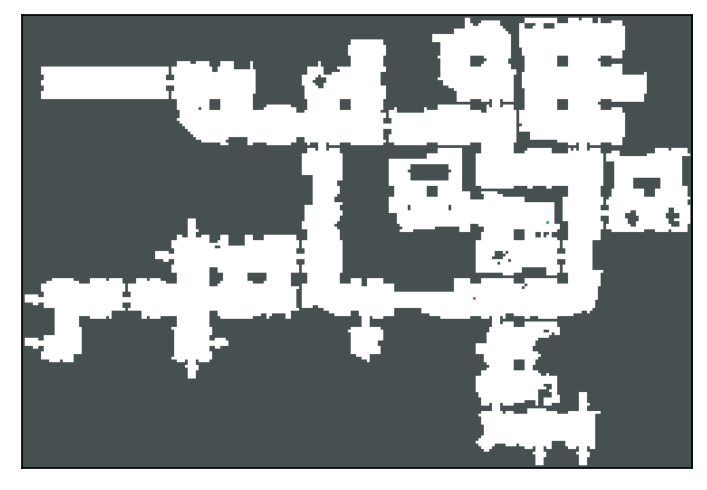

In [16]:
astar_len = massive_test(astar, diagonal_distance)["len"]
jps_len = jps_algo()

assert(len(jps_len) == len(astar_len))

eps = 0.05
for i in range(len(jps_len)):
    if(("True" if jps_len[i] + eps > astar_len[i] and jps_len[i] - eps < astar_len[i] else "False") == "False"):
        print(i, jps_len[i], astar_len[i])